# Determining Sigma 10 & R 10 of DESIJ1205+4110

**Author**: Sulyman Hossain, S M Rafee Adnan, Anowar Shajib

## Load data

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [93]:
data, header = fits.getdata("DESIJ1205+4110_F140W_drz_sci.fits", header=True)

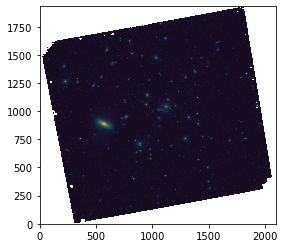

In [94]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_5385/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


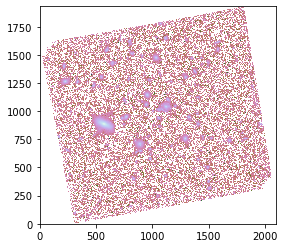

In [95]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [96]:
np.median(bkg.background), np.median(bkg.background_rms)

bkg_subtracted_data = data - bkg.background

threshold = 5 * bkg.background_rms

segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

finder = SourceFinder(npixels=10, progress_bar=False)

segment_map = finder(bkg_subtracted_data, threshold)
print(segment_map)

cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.core.SegmentationImage>
shape: (1932, 2100)
nlabels: 504
labels: [  1   2   3   4   5 ... 500 501 502 503 504]
<photutils.segmentation.catalog.SourceCatalog>
Length: 504
labels: [  1   2   3   4   5 ... 500 501 502 503 504]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

/tmp/ipykernel_5385/1645545376.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


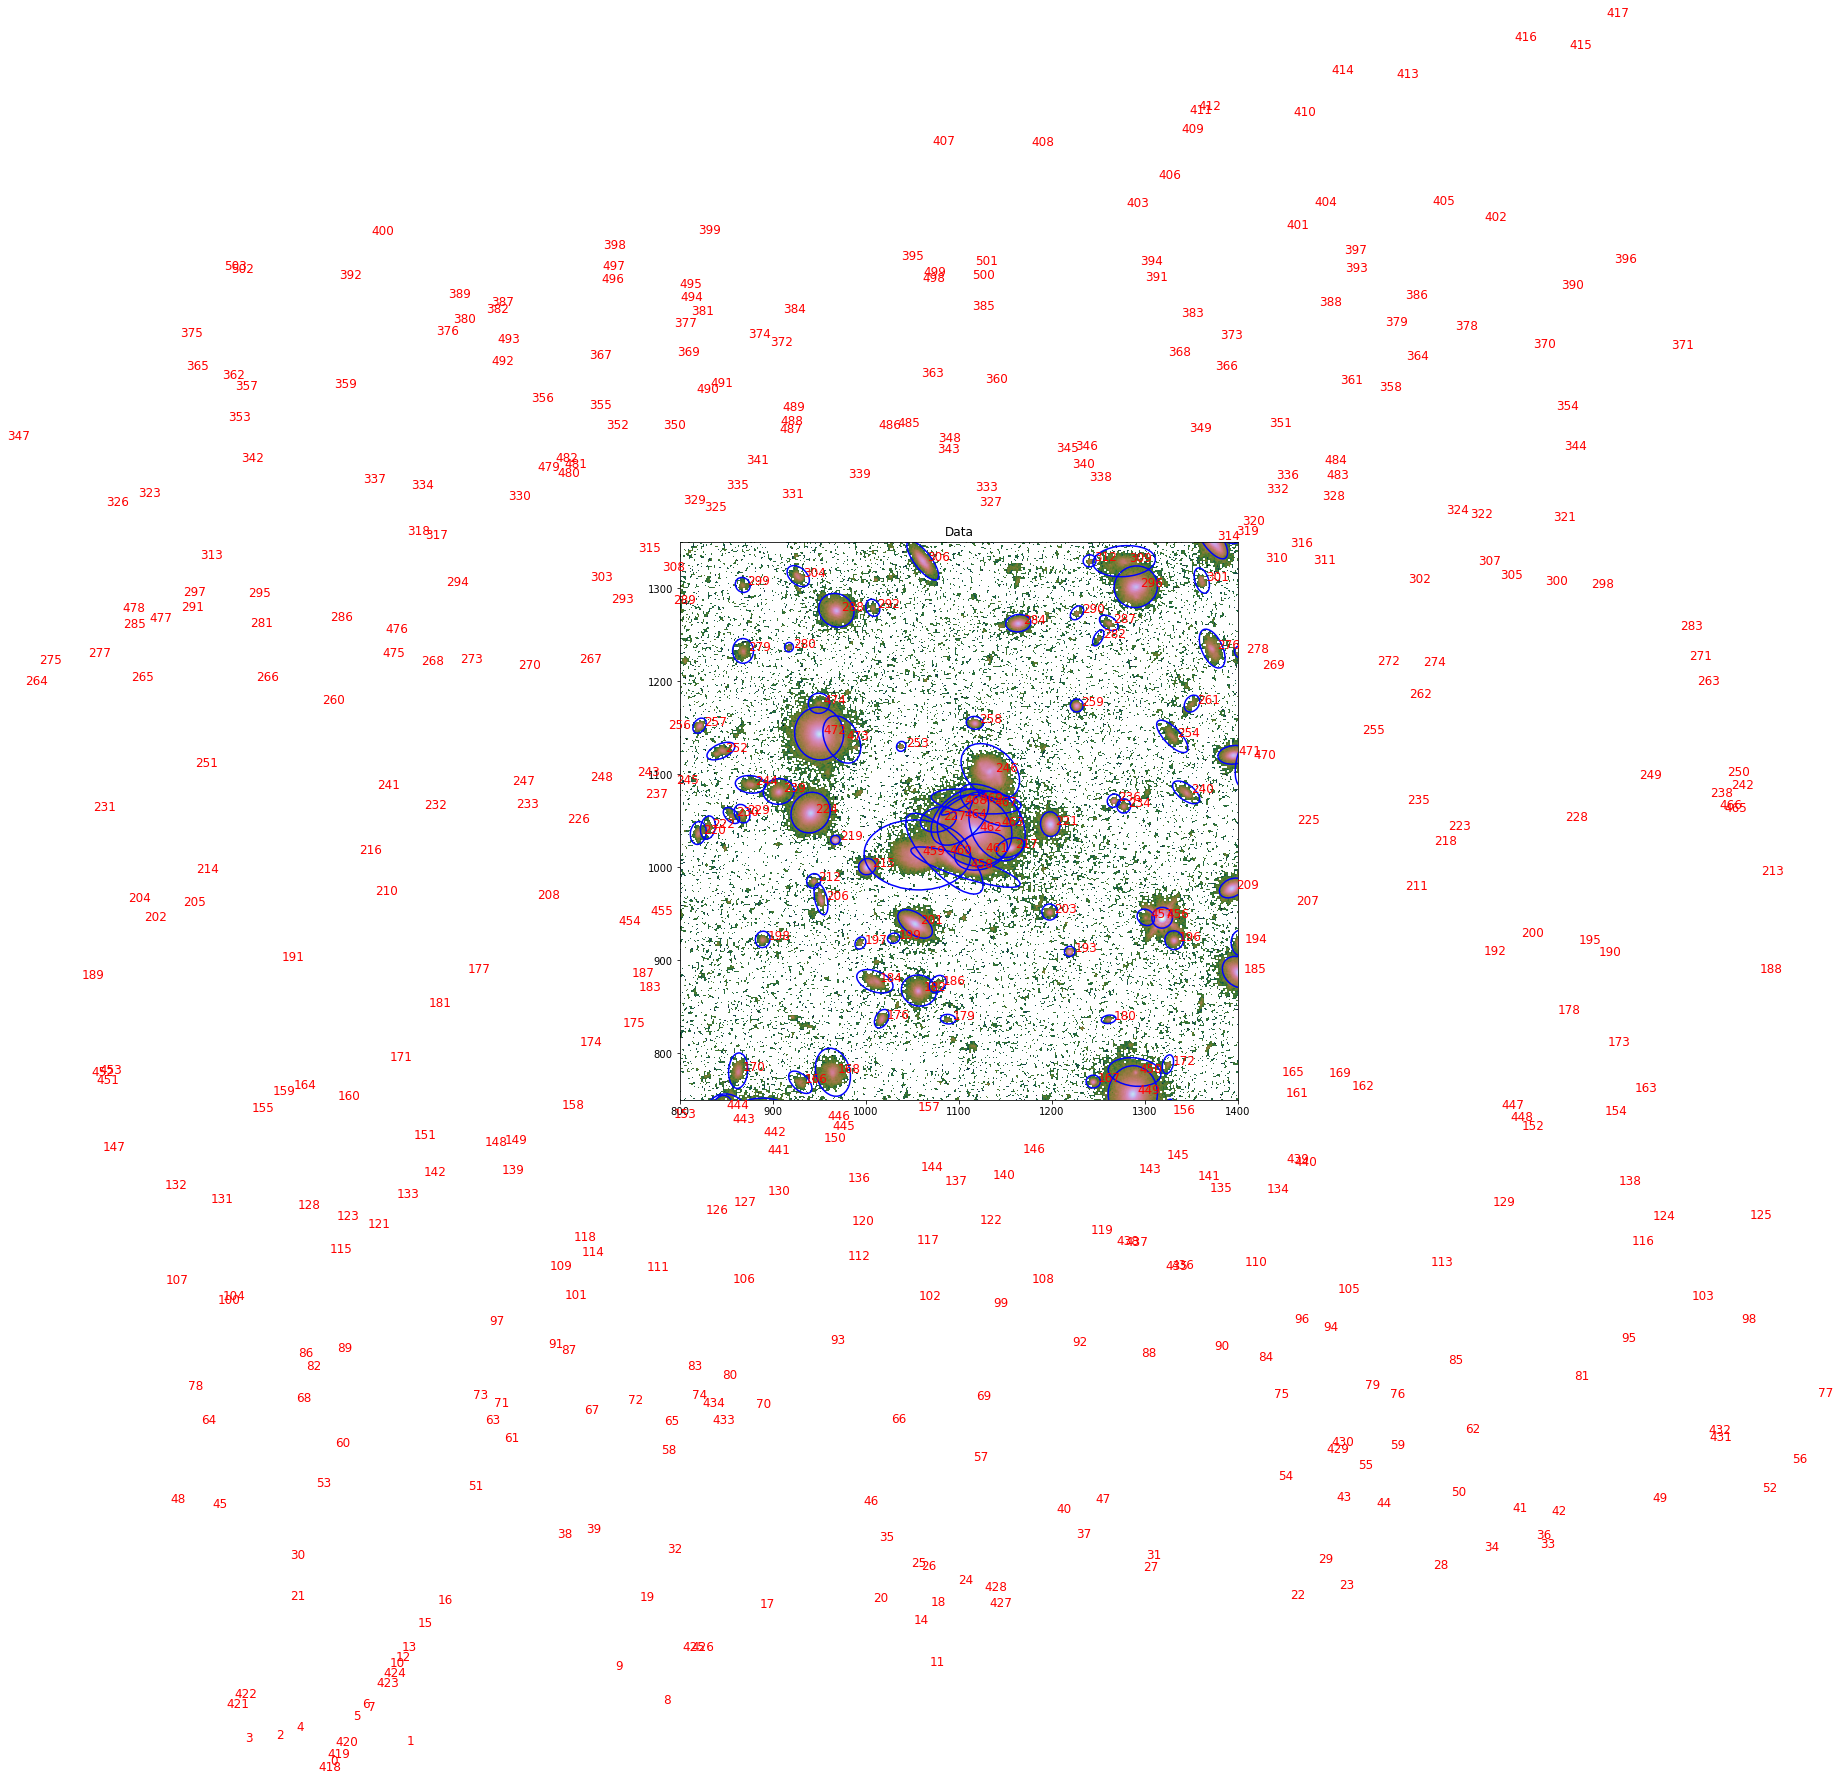

In [97]:
set_x_lim1, set_x_lim2 = 800, 1400
set_y_lim1, set_y_lim2 = 750, 1350

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
    ax1.text(
        cat.xcentroid[i] + 5,
        cat.ycentroid[i],
        f"{i}",
        c="r",
        fontsize=12
        # transform=ax1.transAxes
    )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/tmp/ipykernel_5385/2723595721.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


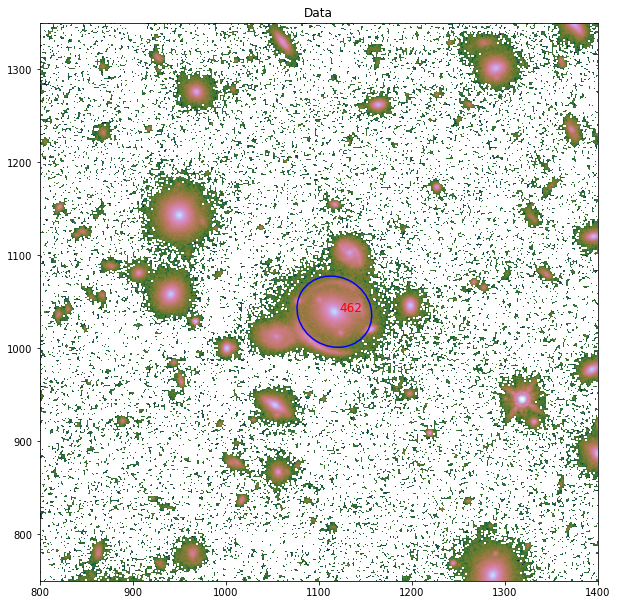

In [98]:
# object id of your central deflector/lens
id_central = 462

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [99]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating A List of Neighboring Galaxies

In [100]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print("Number of All Close galaxies:", len(close_galaxies_all))

Number of All Close galaxies: 47


In [101]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print("Number of Close galaxies excluding dim sources:", len(close_galaxies_1))

Number of Close galaxies excluding dim sources: 34


In [102]:
def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [103]:
# Removing the Stars and Arc objects from the neighboring galaxy list
remove_list = [462, 463, 469, 467, 468, 458, 460, # ARC objects
               203, 215, 219, 234, 193, 259, 212 # Probable Stars
              ]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 10 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)


     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
464         21.363922          1.709114  235.920443    0.614467
461         23.252378          1.860190  141.526328    0.661717
227         40.638350          3.251068   70.703469    0.666984
217         42.690653          3.415252   93.135690    0.609441
246         65.627284          5.250183  317.216603    0.697718
459         66.919078          5.353526  376.934208    0.656407
221         81.764235          6.541139  201.315648    0.792928
258        115.641628          9.251330   23.498824    0.745520
201        119.131816          9.530545  325.244725    0.537086
253        119.976320          9.598106    2.590624    0.892507
199        144.999689         11.599975    3.873261    0.810315
236        153.206967         12.256557    9.410396    0.899124
186        169.848885         13.587911    5.656578    0.759116
197        172.390585         13.791247    3.232929    0.789643
473        173.005948         13.840476 

In [104]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

# Removing the Stars and Arc objects from the neighboring galaxy list
# excluding sources lower than 1% of the central deflector
remove_list_1 = [462, 463, 469, 467, 468, 458, 460, # ARC objects
                215, 219, 193, 259, 456 # Probable Stars
              ]
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 10 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
464         21.363922          1.709114  235.920443    0.614467
461         23.252378          1.860190  141.526328    0.661717
227         40.638350          3.251068   70.703469    0.666984
217         42.690653          3.415252   93.135690    0.609441
246         65.627284          5.250183  317.216603    0.697718
459         66.919078          5.353526  376.934208    0.656407
221         81.764235          6.541139  201.315648    0.792928
258        115.641628          9.251330   23.498824    0.745520
201        119.131816          9.530545  325.244725    0.537086
473        173.005948         13.840476   50.005781    0.661486
224        177.319865         14.185589  409.915236    0.911283
206        180.986379         14.478910   17.623147    0.386920
182        182.306276         14.584502   72.324009    0.873347
184        194.463194         15.557056   31.595538    0.539272
472        196.964081         15.757126 

## Determining Sigma 10, 20 and R 10, 20

/tmp/ipykernel_5385/773936126.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_5385/773936126.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_5385/773936126.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_5385/773936126.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 9.530545251493878
R 20: 18.491978425916923
Sigma 10: 0.03504407747636149
Sigma 20: 0.018617157239635456

FOR All SOURCES
R 10: 9.530545251493878
R 20: 15.55705552225957
Sigma 10: 0.03504407747636149
Sigma 20: 0.0263042134236912


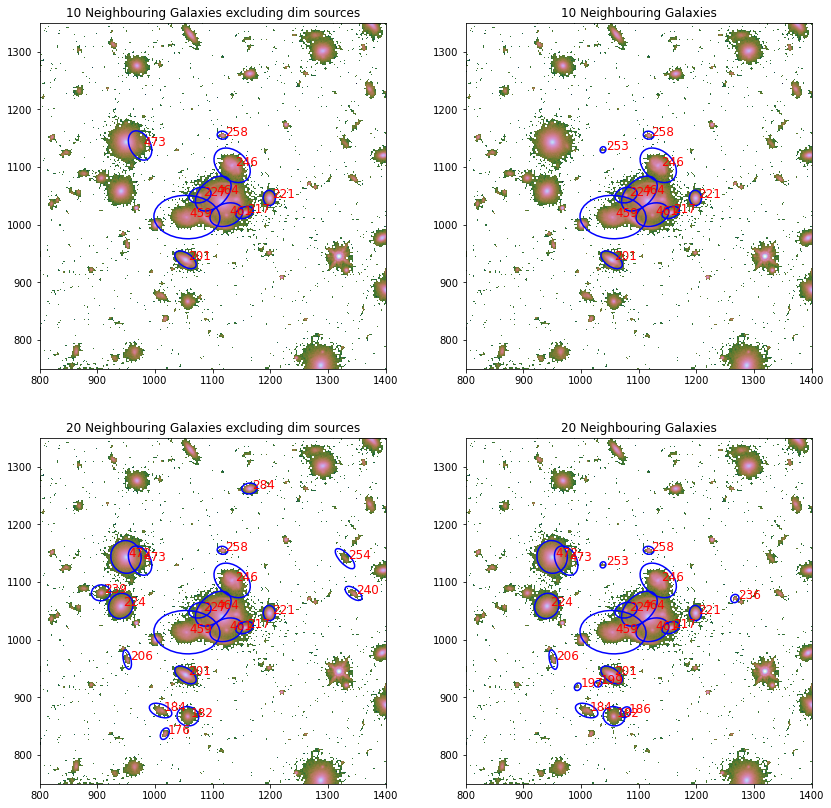

In [105]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[
    9 - 1, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_1 = df_1_20.iloc[
    19 - 1, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[
    9 - 1, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_all = df_all_20.iloc[
    19 - 1, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

## Save the final deriverables to the YAML file

In [108]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1205+4110_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [109]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.890063589750755, 'Sigma_10': 0.03504407747636149, 'Sigma_10_flux_selected': 0.03504407747636149, 'Sigma_20': 0.0263042134236912, 'Sigma_20_flux_selected': 0.018617157239635456, 'center_x_light': [-0.32303844620976147, 0.0004975486956067532, 0.0004939184023614596], 'center_x_mass': [-0.1745065597814682, 0.009996354916700978, 0.008874035930579893], 'center_y_light': [-0.061671095155539396, 0.0008406318416126005, 0.0008679765829558012], 'center_y_mass': [-0.10810074371193056, 0.007417455417669236, 0.006157408469228978], 'gamma': [1.9620695360094522, 0.012895791894527386, 0.01348173971003197], 'gamma_shear': [0.6643131351147986, 0.016097413249878123, 0.015344434059670231], 'phi_light': [0.6774535728326477, 0.008427565271132642, 0.008531858192424746], 'phi_mass': [0.4957704742982046, 0.016334851794064298, 0.013120326925505854], 'phi_shear': [0.12086455837753865, 0.006277875473506639, 0.004148894788421828], 'q_light': [0.793171150772073, 0.00